# **Deep Q-Learning Network (DQN) Reinforcement Learning Agent for Blackjack**

## Imports and Installs
Initially our team tried to use the AgileRL library to implement the deep Q-Learning agent and training loop. However, after initial testing in Gymnasium's CliffWalking env (our agileRL_DQN-Gym-CliffWalking notebook) - we found that AgileRL's main benefit (applying flexible training strategies that leverage colab's GPU) had some drawbacks. Mostly, we found that most Gymnasium environments do use array data structures within their actions or observations - a requirement to use agileRL's classes. We had to wrap the environment and AgileRL's DQN and test loops.

 Furthermore, we found that aside from that, AgileRL's GPU training feature was not functional. We used the reinforcement learning reference book](http://www.incompleteideas.net/book/RLbook2020.pdf) for this problem linked by the gymnasium developers, as well as example boilerplate code provided by Professor Jahan Ghofraniha of our CMPE260 course at San Jose State University.

In [ ]:
%%capture
# capture line to hide the output
# Install required packages
!pip install gymnasium torch numpy matplotlib

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

## **DQN Agent with Replay Memory Implementation**

### What is the difference in training with a DQN agent vs a Q-Learning agent?

#### Memory and Replay buffer
A difference in training an agent with a memory or replay buffer is that the simpler agent.update(state, action, reward, next_state, done) function is decomposed into multiple functions:

1. memory.save_to_memory_vect_envs(state, action, reward, next_state, done)
2. experience = memory.sample(agent.batch_size)
3. agent.learn(experience)

This allows for a higher dimensional input used for training (for example with multiple channels or multiple observations).

#### Training steps

The training steps when using a memory or replay buffer is dependent on the 'batch_size' of the memory. This determines how many 'experiences' / memory samples (or steps in the environment) the memory should be filled with prior to training. Once the memory is filled (this could be taken as the exploration phase as no learning is taking place), the agent continues taking steps while also learning (the training phase).

In [ ]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Define the DQN (Deep Q-Network) architecture
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.network(x)

# Test environment
observation, info = env.reset()
print("Initial Observation:", observation)
print("Available Actions:", env.action_space)
print("Observation Space:", env.observation_space)

Initial Observation: (11, 4, 0)
Available Actions: Discrete(2)
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))


### The BlackjackDQN Class
The neural network architecture within our BlackjackDQN is simple and only contains 3 feed-forward layers. Given the discrete actions and observations we did not expect many layers were needed. After training, we found we could improve our models performance, and this architecture could be altered to increase the width and depth of the network.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class BlackjackDQN(nn.Module):
    def __init__(self):
        super(BlackjackDQN, self).__init__()

        # Input size: 3 (player sum, dealer card, usable ace)
        # Output size: 2 (stand or hit)
        self.network = nn.Sequential(
            nn.Linear(3, 64),      # Input layer
            nn.ReLU(),            # Activation function
            nn.Linear(64, 64),    # Hidden layer
            nn.ReLU(),            # Activation function
            nn.Linear(64, 2)      # Output layer (Q-values for each action)
        )

    def forward(self, state):
        # Convert state to tensor if it's not already
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)

        # Ensure state is in the correct shape
        if state.dim() == 1:
            state = state.unsqueeze(0)  # Add batch dimension

        return self.network(state)

# Initialize the network
model = BlackjackDQN()

# Test the network with a sample state
sample_state = np.array([11, 9, 0])  # From your initial observation
output = model(sample_state)
print(f"Network output for sample state: {output}")

Network output for sample state: tensor([[-1.1749, -0.2710]], grad_fn=<AddmmBackward0>)


### The ReplayMemory Class

This is our ReplayMemory implementation which is a simple deque that captures individual observations from the environment. This is used to save experiences during the exploration phase (when the model is making actions at random) to save for later use during training.

In [ ]:
import random
from collections import namedtuple, deque

# Define a named tuple to store experiences
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, action, reward, next_state, done):
        """Save an experience to memory"""
        experience = Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory"""
        if batch_size > len(self.memory):
            batch_size = len(self.memory)
        experiences = random.sample(self.memory, batch_size)

        # Convert to separate arrays
        states = torch.FloatTensor([exp.state for exp in experiences])
        actions = torch.LongTensor([exp.action for exp in experiences])
        rewards = torch.FloatTensor([exp.reward for exp in experiences])
        next_states = torch.FloatTensor([exp.next_state for exp in experiences])
        dones = torch.FloatTensor([exp.done for exp in experiences])

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

# Initialize replay memory
memory = ReplayMemory()

# Test the replay memory with a sample experience
sample_experience = (
    np.array([11, 9, 0]),  # state
    1,                     # action (hit)
    0,                     # reward
    np.array([16, 9, 0]),  # next_state
    False                  # not done
)

memory.push(*sample_experience)
print(f"Memory size after pushing one experience: {len(memory)}")

# Test sampling (this will only return the one experience we pushed)
states, actions, rewards, next_states, dones = memory.sample(1)
print("\nSampled experience:")
print(f"State: {states}")
print(f"Action: {actions}")
print(f"Reward: {rewards}")
print(f"Next State: {next_states}")
print(f"Done: {dones}")

Memory size after pushing one experience: 1

Sampled experience:
State: tensor([[11.,  9.,  0.]])
Action: tensor([1])
Reward: tensor([0.])
Next State: tensor([[16.,  9.,  0.]])
Done: tensor([0.])


<ipython-input-5-e10c27bf46a4>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([exp.state for exp in experiences])


### The ImprovedDQNAgent Class
This class is in effect the final model we implemented as an improvement over our initial BlackjackDQN class. This model is deeper and wider and also has additional features related to reinforcement learning concepts. We split the model into two network's (i.e one that learns the policy/q-matrix 'the policy net', and another that learns the actions without reference to the states 'the target net') and this is used to implement off-policy training.

In [ ]:
import torch.optim as optim

class ImprovedDQNAgent:
    def __init__(self, input_dim=3, learning_rate=5e-4, gamma=0.99, epsilon=1.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fitness = [] # used to store a series of 'avg reward' during evaluation

        # Larger network
        self.policy_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        ).to(self.device)

        self.target_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        ).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(capacity=20000)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99997
        self.batch_size = 128
        self.target_update = 10
        self.episode_count = 0

    def select_action(self, state):
        """Select action using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            return random.randint(0, 1)

        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()

    def update_epsilon(self):
        """Decay epsilon value"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay memory"""
        self.memory.push(state, action, reward, next_state, done)

    def train_step(self):
        """Perform one training step"""
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Double DQN implementation
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Huber loss for better stability
        loss = nn.SmoothL1Loss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Update target network parameters"""
        if self.episode_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.episode_count += 1

# Initialize the improved agent
agent = ImprovedDQNAgent()

# Modified training function
def train_agent(num_episodes=2000, print_interval=100):
    rewards = []
    losses = []
    epsilons = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Select and perform action
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # Store transition
            agent.store_transition(state, action, reward, next_state, done)

            # Move to next state
            state = next_state
            episode_reward += reward

            # Perform training step
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)

        # Update target network
        agent.update_target_network()

        # Update exploration rate
        agent.update_epsilon()

        # Store metrics
        rewards.append(episode_reward)
        epsilons.append(agent.epsilon)

        # Print progress
        if (episode + 1) % print_interval == 0:
            avg_reward = np.mean(rewards[-print_interval:])
            avg_loss = np.mean(losses[-print_interval:]) if losses else 0
            print(f"Episode {episode + 1}")
            print(f"Average Reward: {avg_reward:.3f}")
            print(f"Average Loss: {avg_loss:.3f}")
            print(f"Epsilon: {agent.epsilon:.3f}")
            print("-" * 50)

    return rewards, losses, epsilons

# Test with a small number of episodes first
print("Starting training...")
rewards, losses, epsilons = train_agent(num_episodes=10, print_interval=5)
print("Initial training completed!")

Starting training...
Episode 5
Average Reward: 0.200
Average Loss: 0.000
Epsilon: 1.000
--------------------------------------------------
Episode 10
Average Reward: 0.400
Average Loss: 0.000
Epsilon: 1.000
--------------------------------------------------
Initial training completed!


# **Training**

## Visualizing the Training of the Agent over 500,000 Episodes using a Plot of Rewards, Loss, and Epsilon
A decay rate of 0.99997 allows for more exploration up to ~100,000 episodes before reaching the minimum epsilon value. Training will occur for the rest of the 400,000 episodes. 500,000 episodes was shown to be a benchmark value to capture the optimal q-matrix strategy according to the reinforcement learning reference book.

In [ ]:
# Run full training
print("Starting full training session...")
rewards, losses, epsilons = train_agent(num_episodes=500000, print_interval=100000)

Starting full training session...
Episode 100000
Average Reward: -0.166
Average Loss: 0.229
Epsilon: 0.050
--------------------------------------------------
Episode 200000
Average Reward: -0.076
Average Loss: 0.225
Epsilon: 0.050
--------------------------------------------------
Episode 300000
Average Reward: -0.081
Average Loss: 0.224
Epsilon: 0.050
--------------------------------------------------
Episode 400000
Average Reward: -0.081
Average Loss: 0.224
Epsilon: 0.050
--------------------------------------------------
Episode 500000
Average Reward: -0.073
Average Loss: 0.228
Epsilon: 0.050
--------------------------------------------------


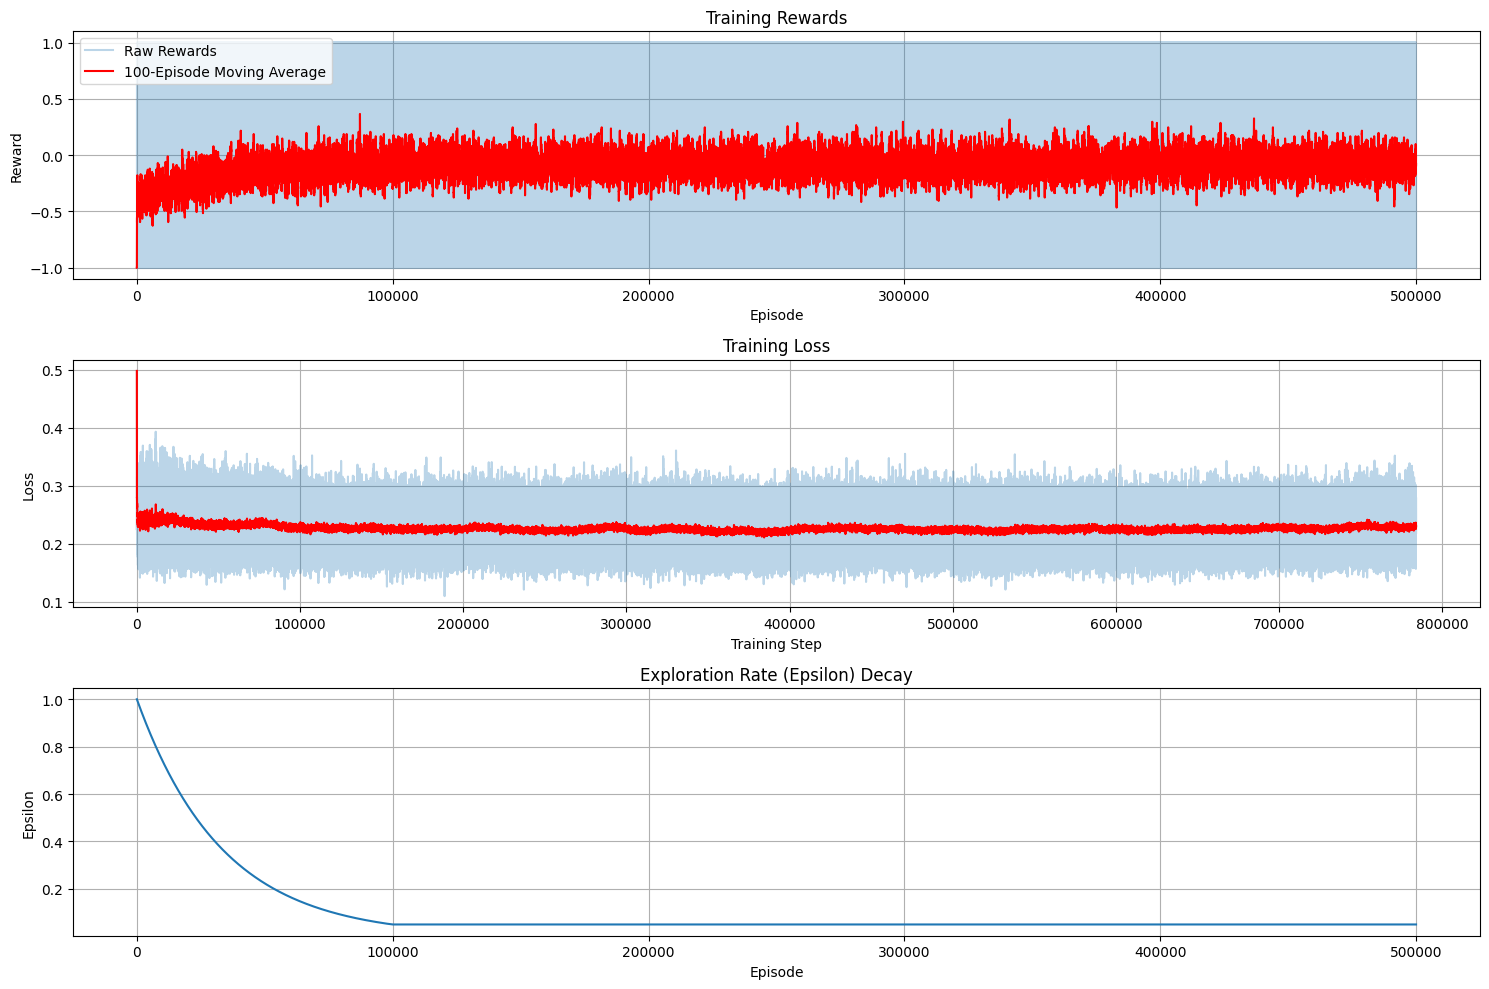

In [ ]:
# Plotting functions with improved visualization
def plot_metrics(rewards, losses, epsilons):
    fig = plt.figure(figsize=(15, 10))

    # Plot rewards with moving average
    plt.subplot(311)
    plt.plot(rewards, alpha=0.3, label='Raw Rewards')
    window_size = 100
    moving_avg = [np.mean(rewards[max(0, i-window_size):i+1])
                 for i in range(len(rewards))]
    plt.plot(moving_avg, 'r', label=f'{window_size}-Episode Moving Average')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)

    # Plot losses with moving average
    plt.subplot(312)
    plt.plot(losses, alpha=0.3, label='Raw Losses')
    moving_avg_loss = [np.mean(losses[max(0, i-window_size):i+1])
                       for i in range(len(losses))]
    plt.plot(moving_avg_loss, 'r', label=f'{window_size}-Episode Moving Average')
    plt.title('Training Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot epsilon decay
    plt.subplot(313)
    plt.plot(epsilons)
    plt.title('Exploration Rate (Epsilon) Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training metrics
plot_metrics(rewards, losses, epsilons)

## Saving the Trained Model

In [ ]:
# Save the trained model
model_path = 'blackjack_dqn.pth'
torch.save({
    'policy_net_state_dict': agent.policy_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
}, model_path)
print(f"\nModel saved to {model_path}")


Model saved to blackjack_dqn.pth
